# Evolution of P($\zeta$) 

## Using $    P_{new}(\zeta) = \int _0^{\infty} \text{d}\zeta_l\int _0^{\infty} \text{d}\zeta_r P(\zeta_l) P(\zeta_r) \delta(\zeta - \zeta_l - \zeta_r)$ and a finite $d\Gamma$ we show how the probability distribution evolves. For $dP=\frac{\partial P}{\partial \zeta}d\Gamma + d\Gamma P(0) P_{new} \frac{\text{d}P(\zeta)}{d\Gamma}$ we use a finite shift to the left of $d\Gamma$ instead of the first order taylor expansion and instead of $d\Gamma * P(0)$ we integrate $P$ over $[0,d\Gamma]$.

## In the evolution, we renormalize the new Probability distribution: this is an action that is not required in theory because it's automatic from the equation.  In this rough code, however, there are numerical issues that make it unprecise: as you can see by uncommenting the printing of the renormalization, it is not always 1. So we renormalize it manually.


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_69150/2632788943.py:27: RuntimeWarning: overflow encountered in exp
  P = 1.0 / (np.exp(arg) + 1.0)


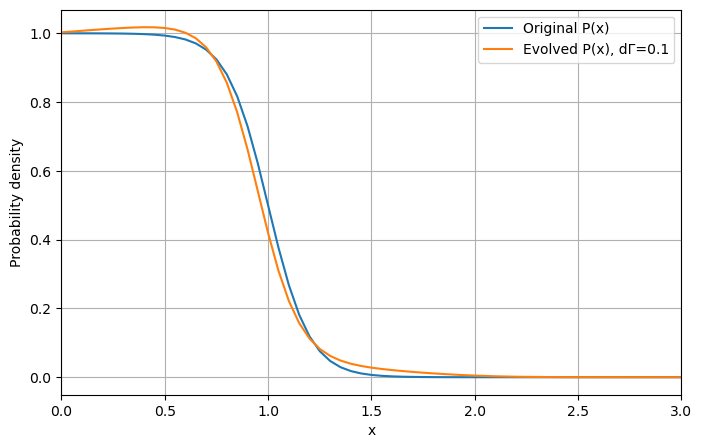

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# ---------------------------------------------------------
# 0. Classical initial probability distributions
# ---------------------------------------------------------

def exponential_P(x, lam=1.0):
    """Exponential distribution on [0,∞)."""
    return lam * np.exp(-lam * x)

def gamma_P(x, k=2, theta=1.0):
    """Gamma distribution."""
    from scipy.stats import gamma
    return gamma.pdf(x, a=k, scale=theta)

def gaussian_cut_P(x, mu=2.0, sigma=0.5):
    """Gaussian truncated to [0,∞)."""
    P = np.exp(-(x-mu)**2/(2*sigma**2))
    return np.where(x >= 0, P, 0)

def fermi_dirac_P(x, mu=1.0, T=0.2):
    """Finite-temperature Fermi-Dirac distribution on [0,∞) (numerically normalized)."""
    # Avoid overflow in exp((x - mu)/T)
    arg = (x - mu) / T
    P = 1.0 / (np.exp(arg) + 1.0)
    
    # Make sure it's zero for negative energies (if x-grid includes them)
    P = np.where(x >= 0, P, 0)
    
    # Normalize numerically
    norm = np.trapezoid(P, x)
    if norm > 0:
        P /= norm
    
    return P



# ---------------------------------------------------------
# 1. Set up x-grid
# ---------------------------------------------------------
x_max = 100.0
x_max_plot = 3
N = 2000
x = np.linspace(0, x_max, N)
dx = x[1] - x[0]

dGamma = 0.1

# ---------------------------------------------------------
# 2. Choose initial distribution
# ---------------------------------------------------------
def initial_P(x):
    #return gamma_P(x, k=2, theta=1.0)
    #return gaussian_cut_P(x, mu=2.0, sigma=0.5)
    #return exponential_P(x, lam=1.0)
    return fermi_dirac_P(x, mu=1.0, T=0.1)

P = initial_P(x)
P /= np.trapezoid(P, x)      # normalize


# ---------------------------------------------------------
# 3. Evolution step
# ---------------------------------------------------------
def evolve(P, x, dGamma):
    dx = x[1] - x[0]
    N = len(x)

    # -----------------------------
    # Exact left shift by dGamma
    # -----------------------------
    shift_idx = int(dGamma / dx)
    P_shift = np.zeros_like(P)
    if shift_idx < N:
        P_shift[:-shift_idx] = P[shift_idx:]

    # -----------------------------
    # Correct "delta" convolution (careful with limits)
    # -----------------------------
    P_conv = np.zeros_like(P)
    for i in range(N):
        # indices j corresponding to ζ_l in [0, ζ = x[i]]
        j_max = i + 1  # x[j] <= x[i]
        if j_max > 0:
            # ζ_r = x[i] - x[j]
            P_r = P[i - np.arange(j_max)]
            P_l = P[:j_max]
            P_conv[i] = np.sum(P_l * P_r) * dx

    # Normalize P_conv to integral 1
    integral_conv = np.trapezoid(P_conv, x)
    if integral_conv > 0:
        P_conv /= integral_conv

    #print("Integral of P_conv(x):", np.trapezoid(P_conv, x))

    # -----------------------------
    # Integral of P_initial(x) from 0 to dGamma
    # -----------------------------
    mask = x <= dGamma
    A0 = np.trapezoid(P_initial[mask], x[mask])

    # -----------------------------
    # Updated evolution equation
    # -----------------------------
    P_new = P_shift + A0 * P_conv

    # enforce physical positivity
    P_new = np.maximum(P_new, 0)

    #print("renormalization of P_new without renormalizing", np.trapezoid(P_new, x))
    
    P_new = P_new/np.trapezoid(P_new,x)

    return P_new




# ---------------------------------------------------------
# 4. Apply one evolution step
# ---------------------------------------------------------
P_new = evolve(P, x, dGamma)


# ---------------------------------------------------------
# 5. Plot original & evolved distributions
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(x, P, label="Original P(x)")
plt.plot(x, P_new, label=f"Evolved P(x), dΓ={dGamma}")
plt.xlabel("x")
plt.xlim(0,x_max_plot)
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()


# Weight redistribution over each decimation step

## The red area is the amount of weight lost from removing the strongest bond: it is the area lost by translating the probability distribution of $d\Gamma$ to the left. The blue area is the weight added by summing the new probability distribution. 

## Normalizing by hand in the evolve function actually enforces that these two areas are the same, but even without that, in a numerically stabel code (not this one) this should be the case by construction of the evolution. This is merely a graphical depiction.

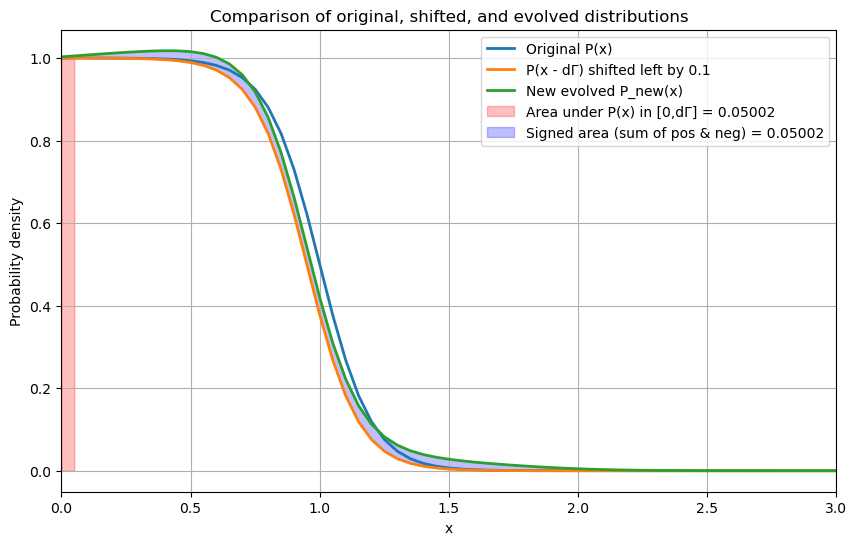

Calculated areas:
  Area1 (under P(x) from 0 to dΓ): 0.050021772622528195
  Signed area (P_new - P_shift): 0.050021772622528535


In [270]:
# ---------------------------------------------------------
# Plot: original P(x), shifted P(x - dGamma), and new P_new(x)
# with shaded regions and signed area values
# ---------------------------------------------------------

# Build shifted distribution P(x - dGamma)
P_shift = np.zeros_like(P)
shift_idx = int(dGamma / dx)
if shift_idx < len(P):
    P_shift[0:len(P)-shift_idx] = P[shift_idx:]

plt.figure(figsize=(10,6))

# Plot curves
plt.plot(x, P, label="Original P(x)", linewidth=2)
plt.plot(x, P_shift, label=f"P(x - dΓ) shifted left by {dGamma}", linewidth=2)
plt.plot(x, P_new, label="New evolved P_new(x)", linewidth=2)

# ---------------------------------------------------------
# Region 1: Area under original P(x) from 0 to dGamma
# ---------------------------------------------------------
mask_region1 = (x >= 0) & (x <= dGamma)
area1 = np.trapezoid(P[mask_region1], x[mask_region1])

plt.fill_between(
    x[mask_region1], P[mask_region1],
    color="red", alpha=0.25,
    label=f"Area under P(x) in [0,dΓ] = {area1:.5f}"
)

# ---------------------------------------------------------
# Region 2: SIGNED area between new P_new(x) and shifted P_shift(x)
# ---------------------------------------------------------

diff = P_new - P_shift
area_signed = np.trapezoid(diff, x)

# Masks for shading positive/negative parts
mask_pos = diff > 0
mask_neg = diff < 0

# Shade positive area (blue)
plt.fill_between(
    x, P_shift, P_new,
    where=mask_pos,
    color="blue", alpha=0.25,
    label=f"Signed area (sum of pos & neg) = {area_signed:.5f}"
)

# Shade negative area (orange)
plt.fill_between(
    x, P_shift, P_new,
    where=mask_neg,
    color="blue", alpha=0.25
)

plt.xlabel("x")
plt.xlim(0, x_max_plot)
plt.ylabel("Probability density")
plt.grid(True)
plt.legend()
plt.title("Comparison of original, shifted, and evolved distributions")
plt.show()

print("Calculated areas:")
print("  Area1 (under P(x) from 0 to dΓ):", area1)
print("  Signed area (P_new - P_shift):", area_signed)


# Many steps evolution

## Here we evolve a probability distribution 50 steps to see that it converges to an exponential distribution, which is the global attractor for this evolution, and it gets broadening at each step, highlighting the infinte disorder fixed point. Indeed, the exp distribution remains exp but broadens.

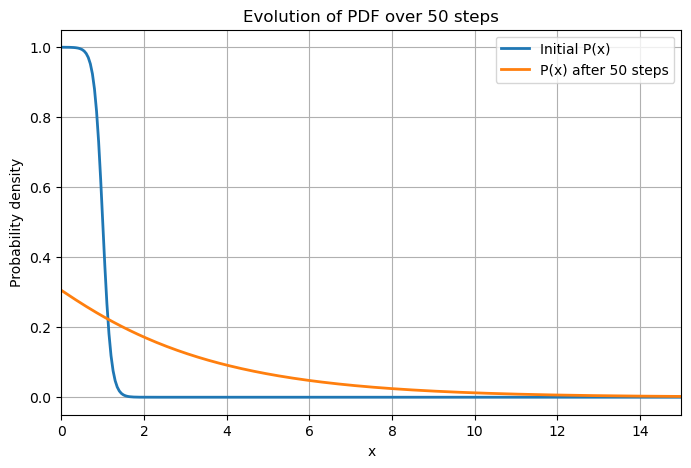

In [272]:
# ---------------------------------------------------------
# Evolve the distribution multiple times and plot initial & final
# ---------------------------------------------------------

n_steps = 50  # number of evolution steps

# Start from the initial distribution
P_current = P.copy()

for step in range(n_steps):
    P_current = evolve(P_current, x, dGamma)

# Plot initial and final distributions
plt.figure(figsize=(8,5))
plt.plot(x, P, label="Initial P(x)", linewidth=2)
plt.plot(x, P_current, label=f"P(x) after {n_steps} steps", linewidth=2)
plt.xlabel("x")
plt.xlim(0,15)
plt.ylabel("Probability density")
plt.grid(True)
plt.legend()
plt.title(f"Evolution of PDF over {n_steps} steps")
plt.show()
